In [1]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
n_qu = 4
dev = qml.device('default.qubit', wires=2*n_qu)

def ansatz(params, n_qu, all_entangled = False):
    # Length of Params : 3 * num_qubit
    for i in range(2*n_qu):
        qml.RX(params[:, 3*i], i)
        qml.RY(params[:, 3 * i + 1], i)
        qml.RZ(params[:, 3 * i + 2], i)
    for i in range(2*n_qu - 1):
        qml.CNOT([i, i + 1])
    if all_entangled:
        qml.CNOT([2*n_qu - 1, 0])

def embedding(params, n_qu, is_first):
    for i in range(n_qu):
        qml.Hadamard(wires=i if is_first else i+n_qu)
        qml.RZ(2.0*params[:,i], wires=i if is_first else i+n_qu)
    
    for i in range(n_qu-1):
        qml.IsingZZ(2.0*params[:, i] ,wires = [i if is_first else i+n_qu, i+1 if is_first else i+n_qu+1])

@qml.qnode(device=dev, interface='torch')
def quantum_layer(mapped_data1, mapped_data2, parameter, n_qu):
    embedding(params=mapped_data1, n_qu=n_qu, is_first=True)
    embedding(params=mapped_data2, n_qu=n_qu, is_first=False)
    qml.Barrier()
    ansatz(params=parameter, n_qu = n_qu)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qu)]

(<Figure size 1900x900 with 1 Axes>, <Axes: >)

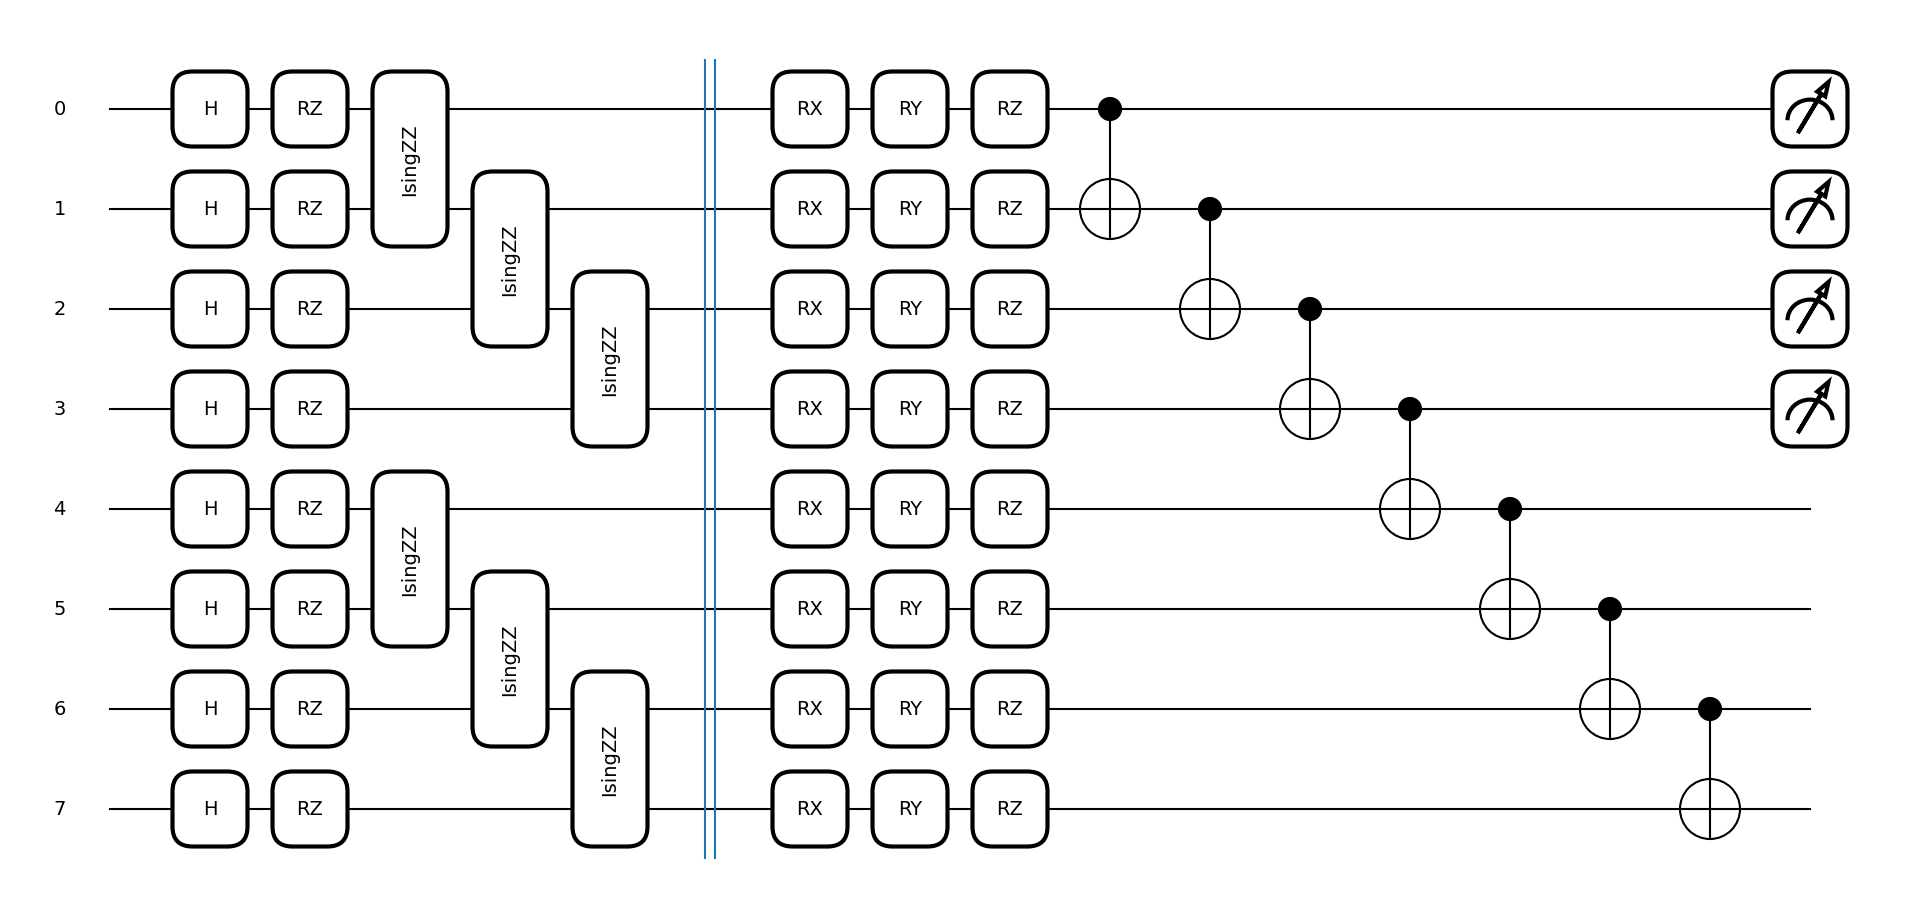

In [3]:
qml.draw_mpl(quantum_layer)(torch.rand(1,2*n_qu-1), torch.rand(1,2*n_qu-1), torch.rand(1,6*n_qu), n_qu=n_qu)

In [45]:
class QGRU(nn.Module):
    def __init__(self, n_qu):
        self.n_qu = n_qu
        super(QGRU, self).__init__()
        for i in range(3):
            setattr(self,f'ql{i}', quantum_layer)

        self.cls_layer = nn.Sequential(nn.Linear(n_qu,8),nn.ReLU(),nn.Linear(8,1)).to(torch.float32)
        
        self.ansatz_params_1 = nn.Parameter(torch.rand([1,6*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_2 = nn.Parameter(torch.rand([1,6*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_3 = nn.Parameter(torch.rand([1,6*n_qu],dtype = torch.float32),requires_grad=True)

    def nQE_layer(self, input):
        n_qu = input.shape[1]
        n_batch = input.shape[0]
        for i in range(n_qu-1):
            input = torch.cat(([input,((torch.pi-input[:,i])*(torch.pi-input[:,i+1])).reshape(n_batch,1)]),1)
        return input

    def forward(self, inputs, return_hidden_list = False):
        batch = inputs.shape[0]
        seq_len = inputs.shape[1]
        n_qu = inputs.shape[2]
        inputs = inputs.permute(1,0,2)
        h0 = torch.zeros(batch,n_qu)
        input0 = self.nQE_layer(inputs[0])
        r0 = torch.stack(self.ql0(input0, self.nQE_layer(h0), self.ansatz_params_1, n_qu),dim=1)
        z0 = torch.stack(self.ql1(input0, self.nQE_layer(h0), self.ansatz_params_2, n_qu),dim=1)
        n0 = torch.stack(self.ql2(input0, r0, self.ansatz_params_3, n_qu),dim=1)
        hidden = (1-z0)*n0+z0*h0
        if return_hidden_list:
            hidden_list = hidden
        for input in inputs[1:]:
            input = self.nQE_layer(input)
            h = hidden
            ah = self.nQE_layer(hidden)
            r = torch.stack(self.ql0(input, ah, self.ansatz_params_1, n_qu),dim=1)
            z = torch.stack(self.ql1(input, ah, self.ansatz_params_2, n_qu),dim=1)
            n = torch.stack(self.ql2(input, r, self.ansatz_params_3, n_qu),dim=1)
            hidden = (1-z)*n+z*h
            if return_hidden_list:
                hidden_list = torch.concat([hidden_list, hidden])
        if return_hidden_list:
            hidden_list = torch.reshape(hidden_list,[batch, seq_len,-1])
            return hidden_list
        return self.cls_layer(hidden.to(torch.float32))

In [46]:
import pandas as pd

n_train = 50
df = pd.read_csv('./dataset.csv')
print(df)

                  datetime  nat_demand    T2M_toc  QV2M_toc   TQL_toc  \
0      2015-01-03 01:00:00    970.3450  25.865259  0.018576  0.016174   
1      2015-01-03 02:00:00    912.1755  25.899255  0.018653  0.016418   
2      2015-01-03 03:00:00    900.2688  25.937280  0.018768  0.015480   
3      2015-01-03 04:00:00    889.9538  25.957544  0.018890  0.016273   
4      2015-01-03 05:00:00    893.6865  25.973840  0.018981  0.017281   
...                    ...         ...        ...       ...       ...   
48043  2020-06-26 20:00:00   1128.5592  27.246545  0.020303  0.055511   
48044  2020-06-26 21:00:00   1112.7488  27.099573  0.020395  0.053848   
48045  2020-06-26 22:00:00   1081.5680  26.971155  0.020448  0.057251   
48046  2020-06-26 23:00:00   1041.6240  26.867487  0.020464  0.064178   
48047  2020-06-27 00:00:00   1013.5683  26.750330  0.020441  0.063965   

         W2M_toc    T2M_san  QV2M_san   TQL_san    W2M_san    T2M_dav  \
0      21.850546  23.482446  0.017272  0.001855  1

In [53]:
y_train = torch.tensor(df['nat_demand'].to_numpy()[:n_train]).to(torch.float).reshape(1,50,1)
print(y_train.shape)
x_train = torch.tensor(df[sorted("T2M_toc	QV2M_toc TQL_toc W2M_toc T2M_san QV2M_san TQL_san W2M_san T2M_dav QV2M_dav TQL_dav W2M_dav".split())].to_numpy()[:n_train]).to(torch.float)
print(x_train.shape)

xs = torch.tensor([(x_train[:,3 * i : 3 * i + 3].sum(dim=1)/3).tolist() for i in range(4)]).T.reshape(1,50,4)
#y_train = (y_train-y_train.min())/(y_train.max()-y_train.min())


import torch.optim as optim
# Define the training loop



def train_layer(inputs,targets,model):
    # Parameters
    num_epochs = 500
    learning_rate = 0.2


    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Dummy data for training

    # Training loop
    for epoch in range(num_epochs):

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.to(torch.float32)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

torch.Size([1, 50, 1])
torch.Size([50, 12])


In [54]:
model = QGRU(4).to(torch.float32)

In [55]:
train_layer(xs.to(torch.float32), y_train.to(torch.float32), model)

/Users/jeon-yuseong/miniconda3/envs/penny_torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 50, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/500], Loss: 1076137.3750
Epoch [2/500], Loss: 1075223.2500
Epoch [3/500], Loss: 1074069.7500
Epoch [4/500], Loss: 1072090.7500
Epoch [5/500], Loss: 1068951.2500
Epoch [6/500], Loss: 1064471.5000
Epoch [7/500], Loss: 1058890.5000
Epoch [8/500], Loss: 1053203.7500
Epoch [9/500], Loss: 1045896.8125
Epoch [10/500], Loss: 1037101.2500
Epoch [11/500], Loss: 1027466.5000
Epoch [12/500], Loss: 1016006.6250
Epoch [13/500], Loss: 1002249.1250
Epoch [14/500], Loss: 986216.0000
Epoch [15/500], Loss: 968299.8125
Epoch [16/500], Loss: 948492.0000
Epoch [17/500], Loss: 928357.6875
Epoch [18/500], Loss: 907706.5000
Epoch [19/500], Loss: 885891.9375
Epoch [20/500], Loss: 862132.6250
Epoch [21/500], Loss: 836294.3750
Epoch [22/500], Loss: 808483.5000
Epoch [23/500], Loss: 779296.9375
Epoch [24/500], Loss: 749222.0625
Epoch [25/500], Loss: 718772.8125
Epoch [26/500], Loss: 687639.1875
Epoch [27/500], Loss: 654609.3750
Epoch [28/500], Loss: 620000.3750
Epoch [29/500], Loss: 584305.6250
Epoch [30/

KeyboardInterrupt: 